# MIE524 - Assignment 3
Please complete this notebook for Assignment 3.

## Q2 - Locality-Sensitive Hashing for Approximate Nearest Neighbour

In [1]:
import numpy as np
import random
import time
import unittest
from PIL import Image
from sklearn.model_selection import train_test_split
from collections import defaultdict

In [2]:
def l1(u, v):
    """
    Finds the L1 distance between two vectors
    u and v are 1-dimensional np.array objects
    """
    return np.linalg.norm(u-v, ord=1)

In [3]:
class my_LSH:
    def __init__(self, dataset, n_bands, n_rows):
        """
        Initializes the LSH object
        dataset - dataset to be searched
        n_bands - number of bands
        n_rows - number of rows in each band
        """
        self.n_bands =  n_bands
        self.n_rows =  n_rows

        self.A  =  dataset
        self.bands  =  self.create_bands()
        self.bands_buckets = [defaultdict(set) for band in self.bands]
        self.index_data()

    def create_band_function(self, dimensions, thresholds):
        """
        Creates a g_j function from the original image and compare from a list of dimensions and thresholds.
        Each g_j function generates the j'th band values for a given datapoint (a concatenation of r hash values).
        Each (locality-sensitive) hash value is equal 1 if the corresponding dimension in the original image is higher than the corresppnding threshold.
        """
        def band_function(v):
            boolarray = [v[dimensions[i]] >= thresholds[i] for i in range(len(dimensions))]
            return "".join(map(str, map(int, boolarray)))
        return band_function

    def create_bands(self, num_dimensions=400, min_threshold=0, max_threshold=255):
        """
        Creates the collection of g_j functions 1<=j<=b, one for each band.
        Each function selects r dimensions (i.e. column indices of the image matrix)
        at random, and then chooses a random threshold for each dimension, between 0 and
        255.  For any image, if its value on a given dimension is greater than or equal to
        the randomly chosen threshold, we set that bit to 1.  Each hash function returns
        a length-r bit string of the form "0101010001101001...".
        """
        bands = []
        for i in range(self.n_bands):
            dimensions = np.random.randint(low = 0,
                                        high = num_dimensions,
                                        size = self.n_rows)
            thresholds = np.random.randint(low = min_threshold,
                                        high = max_threshold + 1,
                                        size = self.n_rows)

            bands.append(self.create_band_function(dimensions, thresholds))
        return bands

    def hash_vector(self, v):
        """
        Hashes an individual vector (i.e. image).  This produces an array with b
        entries (one for each band), where each entry is a string of r bits (one for each row).
        """
        return [f(v) for f in self.bands]

    def index_data(self):
        """
        Hashes the data in A, where each row is a datapoint, using the b band
        functions in "functions." For each band, we use the corresponding dictionary (hash table) to index the data point.
        """
        for doc_index in range(self.A.shape[0]):
            doc_hash = self.hash_vector(self.A[doc_index,:])
            for band_idx, doc_band_hash in enumerate(doc_hash):
                self.bands_buckets[band_idx][doc_band_hash].add(doc_index)

    def get_candidates(self, query_vector):
        """
        Retrieve all of the points that hash to one of the same buckets as the query point.
        """
        query_hash = self.hash_vector(query_vector)
        candidates = set()
        for band_idx, query_band_hash in enumerate(query_hash):
          bucket_candidates = self.bands_buckets[band_idx][query_band_hash]
          candidates = candidates.union(bucket_candidates)
        return candidates

    def lsh_search(self, query_vector, num_neighbours=3):
        """
        Run the entire LSH algorithm
        """
        # 1. Get the candidates for nearest neighbours
        # 2. Determine distance of candidates
        # 3. Extract best neighbours
        # 4. Return a list of the best neighbours and a list of the corresponding distances between each neighbour and the query

        # TODO: YOUR CODE HERE
        # 1. Get the candidates for nearest neighbours
        candidates = self.get_candidates(query_vector)

        # 2. Determine distance of candidates
        lsh_neighbours = []
        lsh_dist = []

        for candidate in candidates:
          # Calculate the L1 distance between the query image and the candidate
          distance = l1(query_vector, self.A[candidate])

          # Append the candidate and its distance to the lists
          lsh_neighbours.append(candidate)
          lsh_dist.append(distance)

        # 3. Extract best neighbours
        lsh_neighbours_idx = np.array(lsh_neighbours)
        lsh_dist = np.array(lsh_dist)

        sorted_idx = np.argsort(lsh_dist)
        lsh_neighbours_idx = lsh_neighbours_idx[sorted_idx]

        lsh_dist = lsh_dist[sorted_idx]
        lsh_neighbours_idx = lsh_neighbours_idx[:num_neighbours]
        lsh_dist = lsh_dist[:num_neighbours]

        return lsh_neighbours_idx, lsh_dist


In [4]:
def plot(A, row_nums, base_filename):
    """
    Plots images at the specified rows and saves them each to files.
    """
    for row_num in row_nums:
        patch = np.reshape(A[row_num, :], [20, 20])
        im = Image.fromarray(patch)
        if im.mode != 'RGB':
            im = im.convert('RGB')
        display(im)
        im.save(base_filename + "-" + str(row_num) + ".png")

In [5]:
#### TESTS #####

class TestLSH(unittest.TestCase):
    def test_l1(self):
        u = np.array([1, 2, 3, 4])
        v = np.array([2, 3, 2, 3])
        self.assertEqual(l1(u, v), 4)

    def test_hash_data(self):
        f1 = lambda v: sum(v)
        f2 = lambda v: sum([x * x for x in v])
        A = np.array([[1, 2, 3], [4, 5, 6]])
        self.assertEqual(f1(A[0,:]), 6)
        self.assertEqual(f2(A[0,:]), 14)

        functions = [f1, f2]
        self.assertTrue(np.array_equal(lsh.hash_vector(functions, A[0, :]), np.array([6, 14])))
        self.assertTrue(np.array_equal(lsh.hash_data(functions, A), np.array([[6, 14], [15, 77]])))

    ### You may write your own tests here

### b) Split data with 100 random query points

In [7]:
!unzip '/content/patches.csv.zip' # I added

Archive:  /content/patches.csv.zip
  inflating: patches.csv             
  inflating: __MACOSX/._patches.csv  


In [6]:
import pandas as pd
data = pd.read_csv('patches.csv', sep=',', header=None).to_numpy()
dataset, query_points = train_test_split(data, test_size=100, random_state=42)

In [7]:
## I added to check how dataset and query_points look like
print(dataset.shape)
print(query_points.shape)

(59400, 400)
(100, 400)


### c) Compare LSH and linear search for the 100 query points

In [8]:
# Initialize a my_LSH class
lsh = my_LSH(data, n_rows=24, n_bands=10)

In [9]:
## I added for my understanding
print(query_points[0].shape)

(400,)


In [10]:
start_time = time.time()
lsh_neighbours, lsh_dist = lsh.lsh_search(query_points[0],3)
end_time = time.time()
print("Time Taken:", end_time - start_time)

Time Taken: 0.04636240005493164


In [11]:
## I added for my understanding
actual_neigh = [lsh.A[index] for index in lsh_neighbours]
print(len(lsh_dist))

3


In [12]:
# attempt 2
def linear_search(A, query_vector, num_neighbours):
    """
    Finds the nearest neighbours to a given vector, using linear search.
    """
    # TO DO
    # Calculate the distances between query vector and all vectors in the dataset
    distances = np.array([l1(u, query_vector) for u in A])

    # Sort the distances and get the indices of the nearest neighbors
    nearest_neighbors_idx = np.argsort(distances)[:num_neighbours]

    # Get the distances corresponding to the nearest neighbors
    nearest_neighbors_distances = distances[nearest_neighbors_idx]

    return nearest_neighbors_idx, nearest_neighbors_distances


In [13]:
# TODO: YOUR CODE HERE
# LINEAR
start_time = time.time()
linear_neighbours, linear_dists = linear_search(dataset, query_points[0], num_neighbours=3)
end_time = time.time()
print("Time Taken:", end_time - start_time)

Time Taken: 0.30973172187805176


In [14]:
# For my understading
actual_candidates = [lsh.A[index] for index in linear_neighbours]
print(actual_candidates[0].shape)

(400,)


**What is the average search time for LSH? What about for linear search?** <br>

LSH Time Taken: 0.04636240005493164 <br>
Linear Time Take: 0.30973172187805176 <br>

It is apparent how LSH is much faster than the linear search. It's almost 6x faster.


### d) Plot errors vs b and r

In [54]:
# lsh_error function

def lsh_error(lsh_dist, linear_dist):
    """
    Computes the error measure

    piazza:
    if there are less than 3 neighbours, compute the top k ; 0<k<3.
    if no neighbours, skip in the calculation.
    """
    error_sum, lsh_sum, linear_sum, cnt = 0, 0, 0, 0
    length_quries=100
    num_neighbours=3
    for j in range(length_quries): # from 400x100 of query_points
        lsh_d = lsh_dist[j]
        lin_d = linear_dist[j]

        # if statement to mitigate discussion on piazza
        l = len(lsh_d)
        if l > 0:
          lsh_sum = sum(lsh_d[:l]) # up to the top k amt
          linear_sum = sum(lin_d[:l])
          error_sum += lsh_sum/linear_sum
          cnt+=1 # it may skip, so can't divide by 100
    error_measure = (1/cnt)*error_sum

    return error_measure

In [40]:
## Use the lsh_error to compute LSH for varying B

b_lst = [10,12,14,16,18,20]
r = 24
error_b = {}
error = []
num_neighbours = 3

for b in b_lst:
  print("b:", b)
  lsh = my_LSH(dataset, n_rows=r, n_bands=b)  # Update my LSH object
  lsh_dist = []
  linear_dist = []
  error = []
  # construct lsh_dist and linear_dist
  for j in range(query_points.shape[0]):
    _, lsh_dists = lsh.lsh_search(query_points[j], num_neighbours)
    _, linear_dists = linear_search(dataset, query_points[j], num_neighbours)

    lsh_dist.append(lsh_dists)
    linear_dist.append(linear_dists)

  # compute error
  lsh_err = lsh_error(lsh_dist, linear_dist)
  error.append(lsh_err)

  error_b[b] = error

print(error_b)

b: 10
b: 12
b: 14
b: 16
b: 18
b: 20
{10: [1.0354770349831819], 12: [1.0263646617764368], 14: [1.0244804618808758], 16: [1.0114034826275524], 18: [1.0136492183312502], 20: [1.0122112403912924]}


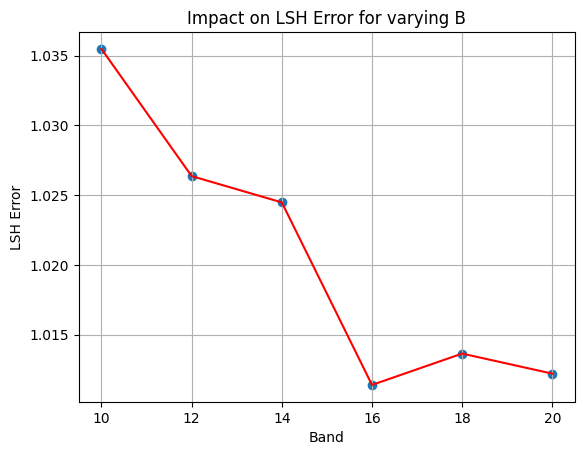

In [41]:
## Plot LSH Error for Varying B

import matplotlib.pyplot as plt

b_val = [10, 12, 14, 16, 18, 20]
data1 = sum(error_b[10])
data2 = sum(error_b[12])
data3 = sum(error_b[14])
data4 = sum(error_b[16])
data5 = sum(error_b[18])
data6 = sum(error_b[20])
data_pt =[data1, data2, data3, data4, data5, data6]

plt.scatter(b_val, data_pt, marker='o')
plt.plot(b_val, data_pt, linestyle='-', color='red', label='Lines')
plt.xlabel('Band')
plt.ylabel('LSH Error')
plt.title('Impact on LSH Error for varying B')
plt.grid(True)  # Add a grid if desired
plt.show()

In [55]:
## Use the lsh_error to compute LSH for varying R

b = 10
r_lst = [16, 18, 20, 22, 24]
error_r = {}
error = []
num_neighbours = 3

for r in r_lst:
  print("r:", r)
  lsh = my_LSH(dataset, n_rows=r, n_bands=b)  # Update my LSH object
  lsh_dist = []
  linear_dist = []
  error = []
  # construct lsh_dist and linear_dist
  for j in range(query_points.shape[0]):
    _, lsh_dists = lsh.lsh_search(query_points[j], num_neighbours)
    _, linear_dists = linear_search(dataset, query_points[j], num_neighbours)

    lsh_dist.append(lsh_dists)
    linear_dist.append(linear_dists)

  # compute error
  lsh_err = lsh_error(lsh_dist, linear_dist)
  error.append(lsh_err)

  error_r[r] = error

print(error_r)

r: 16
r: 18
r: 20
r: 22
r: 24
{16: [1.0089970169926699], 18: [1.0139518671707812], 20: [1.012172220757122], 22: [1.0263801788280376], 24: [1.0499713763428102]}


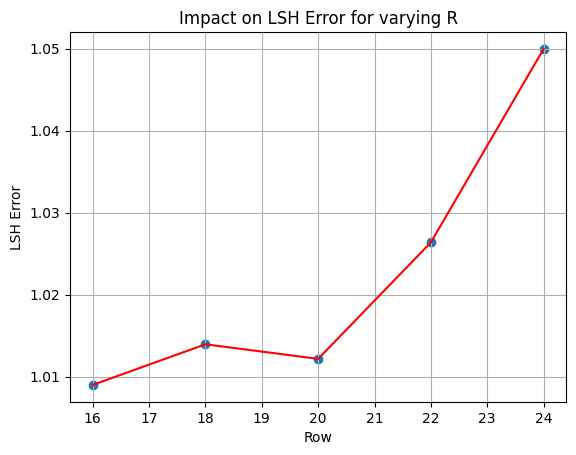

In [56]:
## Plot LSH Error for Varying R

import matplotlib.pyplot as plt

r_val = [16, 18, 20, 22, 24]
data1 = sum(error_r[16])
data2 = sum(error_r[18])
data3 = sum(error_r[20])
data4 = sum(error_r[22])
data5 = sum(error_r[24])
data_pt =[data1, data2, data3, data4, data5]

# Create the scatter plot
plt.scatter(r_val, data_pt, marker='o')
plt.plot(r_val, data_pt, linestyle='-', color='red', label='Lines')
plt.xlabel('Row')
plt.ylabel('LSH Error')
plt.title('Impact on LSH Error for varying R')
plt.grid(True)
plt.show()

**Brief Disccusion:** <br>
As the number of Band increases, the LSH Error decreases. As the number of Row increases, the LSH Error Increases.

In more detail, this aligns with the discussion we had in lecture. As the number of bands increases, the error between LSH search and linear search decreases because increasing the number of bands increases the number of hash functions used, which, in turn, refines the grouping of data points into buckets. On the other hand, as the number of rows increases, the error between LSH search and linear search increases because more rows result in stricter hash functions, which group fewer data points together in the same bucket.

### e) Plot 10 nearest neighbours

In [57]:
# TODO: YOUR CODE HERE

# Plot the top 10 near neighbours found using the two methods (lsh and linear)
# for the image patch in row 100, together with the image patch itself.
# How do they compare visually?

# Modified to have better visual representation
def plot(A, row_nums, base_filename):
    """
    Plots images at the specified rows and saves them each to files.
    """
    plt.figure(figsize=(40, 40))
    for i, row_num in enumerate(row_nums):
        plt.subplot(1, 11, i + 1)
        patch = np.reshape(A[row_num, :], [20, 20])
        im = Image.fromarray(patch)
        if im.mode != 'RGB':
            im = im.convert('RGB')
        plt.subplots_adjust(wspace=0.7)
        plt.imshow(im)
        plt.title(f'Image {i + 1}')
        im.save(base_filename + "-" + str(row_num) + ".png")


In [58]:
lsh = my_LSH(dataset, n_rows=24, n_bands=10)
lsh_neighbours, lsh_dist = lsh.lsh_search(query_points[99],10)

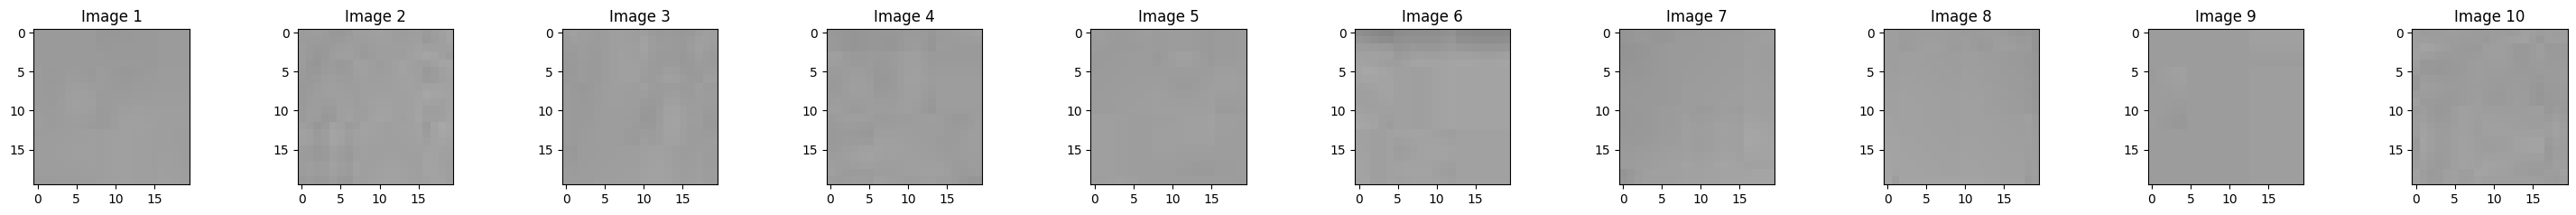

In [59]:
plot(dataset, lsh_neighbours, 'lsh')

In [60]:
linear_neighbours, linear_dists = linear_search(dataset, query_points[99], num_neighbours=10)

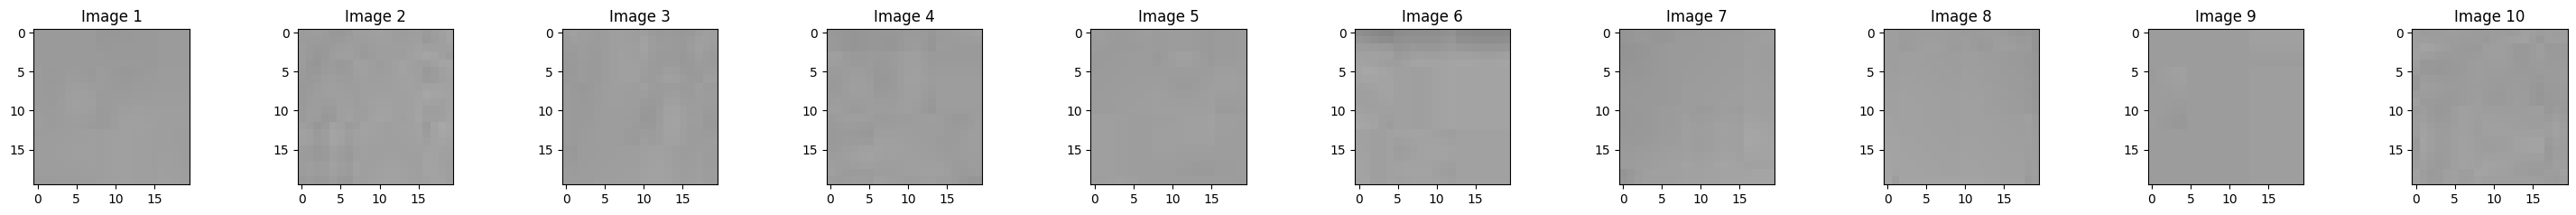

In [61]:
plot(dataset, linear_neighbours, 'linear')

**How do they compare visually?** <br>
They look the same which indicates that LSH method is performing just as well but take less time.

In [62]:
# Double checking
print("lsh_neighbours:", lsh_neighbours)
print("linear_neighbours:", linear_neighbours)

lsh_neighbours: [45824 47717 58733 50966  3351 41879  6360 44680 39004  7689]
linear_neighbours: [45824 47717 58733 50966  3351 41879  6360 44680 39004  7689]
